# Coming from TensorFlow to NengoDL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for people who are familiar with TensorFlow and looking to learn more about neuromorphic modelling with NengoDL.  For the other approach, users familiar with Nengo looking to learn how to use NengoDL, check out [this tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you would want to use it.  Nengo is a tool for constructing and simulating neural networks.  That is, to some extent, the same purpose as TensorFlow (and its higher level API, Keras).  For example, here is how we might build a simple two layer auto-encoder network in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net: 
    # input
    nengo_a = nengo.Node(np.zeros(n_in))
    
    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())
    
    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, 
        transform=nengo_dl.dists.Glorot())
    
    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and the creation of the connections between layers.  This is because the connection structure in Nengo networks often has a lot more state and general complexity than in typical deep learning networks, so it is helpful to be able to control it independently (we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we want to collect the activities of those neurons when the simulation is running.  You can think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality available, but we will focus on the features most familiar or relevant to those coming from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the Nengo-specific [documentation](https://www.nengo.ai/nengo/) and [examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.predict(np.ones((minibatch_size, n_in)));

Again, accomplishing the same thing in Nengo bears many similarities.  We create a `Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, 
                        minibatch_size=minibatch_size) as sim:
    sim.predict(np.ones((minibatch_size, 1, n_in)));

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#####         Constructing graph: build stage (9%)              | ETA: 0:00:00

|##############Constructing graph: build stage (72%)             | ETA: 0:00:00

|  #                      Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

One difference you may note is the extra dimension with size 1 in the shape of the Nengo inputs.  This represents the time dimension; in this example we're only running for a single timestep, which is why it has size 1, but this could be used to provide different input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an abstract set of computations, in Nengo we (almost) always think of the graph as representing a stateful neural simulation, where values are accumulated, updated, and communicated over time.  This is not to say there is no overlap (we can create TensorFlow simulations that execute over time, and we can create Nengo simulations without temporal dynamics), but this is a different way of thinking about computations that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic networks include features drawn from biological neural networks, in an effort to understand or recreate the functionality of biological brains.  Note that these models fall on a spectrum with standard artificial neural networks, with different approaches incorporating different biological features.  But in general the structure and parameterization of these networks often differs significantly from standard deep network architectures.

We touched on this above in the discussion of temporality, which is one common feature of neuromorphic networks.  Another common characteristic is the use of more complicated neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like `relu`) that output a continuous value, spiking neurons communicate via discrete bursts of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps` (or `sim.run`) is a standard Nengo Simulator execution function (as opposed to `sim.predict`, which is specific to NengoDL).  We could use either one, but you will probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in this case is that results will be stored in the `sim.data` dictionary, as opposed to being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|####          Constructing graph: build stage (7%)              | ETA: 0:00:00

|##############Constructing graph: build stage (92%)########     | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

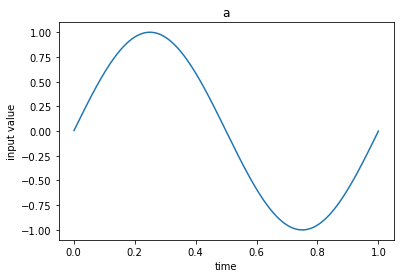

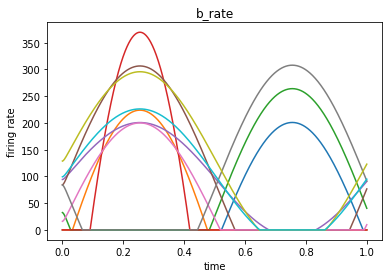

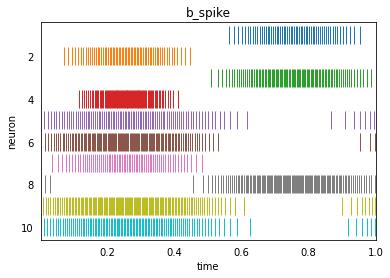

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    
    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(
        10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)
    
    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(
        10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)
    
    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)
    
with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input 
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")
    
plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike");

Each neuron responds to the input signal differently due to the random parameterization in the network (e.g. connection weights and biases).  We have matched the parameterization in the rate and spiking ensembles so that it is easier to see the parallels.

Note that the same information is being represented in the two ensembles.  For example, when the second neuron (orange) is outputting a high continuous value (in the second graph), the corresponding spiking neuron is outputting more discrete spikes (orange lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic filters.  This is inspired by a biological feature where discrete spikes induce a continuous electrical waveform in the receiving neuron, at the synapse (the point where the two neurons connect).  But computationally we can think of this simply as applying a filter to the spiking signal.

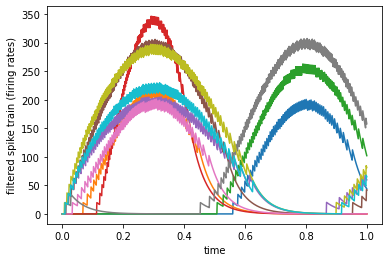

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)");

We can see how the spike trains, when viewed through a synaptic filter, approximate the continuous rate values in the second graph above.  

In this example we have computed the filtered signal manually for demonstration purposes, but in a typical Nengo model these synaptic filters are applied throughout the model, on the `Connection` objects.  For example, the above filtering would be equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and Nengo from a standard deep network background.  Although spiking neurons seem like a radically different paradigm, they can compute and communicate the same information as their rate counterparts.  But note that this only makes sense when we think of the network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete list).  These neuron models have various different behaviours, and managing their parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly work together.  Thus one important feature is the ability to write TensorFlow code directly, and insert it into a Nengo network.  This allows us to use whichever framework is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the rest of a Nengo model.  The TensorFlow code is written in a function that takes `tf.Tensors` as input, applies the desired manipulations through TensorFlow operations, and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose we want to apply batch normalization to the output of one of the Nengo ensembles.  There is no built-in way to do batch normalization in Nengo, so we can instead turn to TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(
        tf.keras.layers.BatchNormalization(momentum=0.9))(b_rate.neurons)
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`, except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this case, and we can add Probes or Connections to `batch_norm` in the same way as any other Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and `Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9), 
        shape_in=(10,), pass_time=False)
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the current simulation time and `x` is the value of any Connections incoming to the TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the `TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The `TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,) + shape_out`, where `shape_out` is the output dimensionality of the node (dependent on the manipulations applied to the inputs `x`).  We could explicitly specify `shape_out=(10,)` in the above example, or if we don't specify the output shape it will be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1]) 
    
    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)
        
        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)
        
    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), 
                            shape_out=(2,))
    nengo.Connection(a, b, synapse=None)
    
    p = nengo.Probe(b)
    
with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

TensorNode input:
t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation time over the 10 timesteps we executed, and `x` contains the value of the input Node that we connected to the TensorNode.  And we can see in the probe data that the TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This can be useful, for example, if the TensorNode requires internal parameters (which should be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:
    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))
        
        def call(self, inputs):
            return inputs * self.w
            
    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), 
                            pass_time=False)

More details on TensorNode usage can be found in [the user guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms, through the `Simulator.fit` function.  Returning to the autoencoder examples from the beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Train on 60000 samples
Epoch 1/2


   32/60000 [..............................] - ETA: 7:40 - loss: 6815.3633

  960/60000 [..............................] - ETA: 18s - loss: 4362.3833 

 1856/60000 [..............................] - ETA: 10s - loss: 3715.6297

 2752/60000 [>.............................] - ETA: 8s - loss: 3318.9669 

 3456/60000 [>.............................] - ETA: 7s - loss: 3096.4748

 4384/60000 [=>............................] - ETA: 6s - loss: 2867.2367

 5312/60000 [=>............................] - ETA: 5s - loss: 2695.9085

 6240/60000 [==>...........................] - ETA: 5s - loss: 2556.5656

 7168/60000 [==>...........................] - ETA: 4s - loss: 2439.7137

 8096/60000 [===>..........................] - ETA: 4s - loss: 2336.9367

 8992/60000 [===>..........................] - ETA: 4s - loss: 2257.9973

 9888/60000 [===>..........................] - ETA: 4s - loss: 2186.8137

10816/60000 [====>.........................] - ETA: 3s - loss: 2123.2431

11744/60000 [====>.........................] - ETA: 3s - loss: 2067.1988

12672/60000 [=====>........................] - ETA: 3s - loss: 2013.2229

13600/60000 [=====>........................] - ETA: 3s - loss: 1966.7009

14528/60000 [======>.......................] - ETA: 3s - loss: 1922.6640

15456/60000 [======>.......................] - ETA: 3s - loss: 1882.9673

16384/60000 [=======>......................] - ETA: 3s - loss: 1845.9939

17280/60000 [=======>......................] - ETA: 2s - loss: 1814.5228

18208/60000 [========>.....................] - ETA: 2s - loss: 1784.1953

19136/60000 [========>.....................] - ETA: 2s - loss: 1755.8649

20064/60000 [=========>....................] - ETA: 2s - loss: 1729.9472

20992/60000 [=========>....................] - ETA: 2s - loss: 1704.1803

21920/60000 [=========>....................] - ETA: 2s - loss: 1680.6892

22848/60000 [==========>...................] - ETA: 2s - loss: 1659.1370

23712/60000 [==========>...................] - ETA: 2s - loss: 1640.3028

24608/60000 [===========>..................] - ETA: 2s - loss: 1620.6913

25504/60000 [===========>..................] - ETA: 2s - loss: 1602.3216

26432/60000 [============>.................] - ETA: 2s - loss: 1584.3140

27328/60000 [============>.................] - ETA: 2s - loss: 1569.2583

28256/60000 [=============>................] - ETA: 2s - loss: 1553.5259

29120/60000 [=============>................] - ETA: 1s - loss: 1538.8872

29472/60000 [=============>................] - ETA: 1s - loss: 1533.2402

30400/60000 [==============>...............] - ETA: 1s - loss: 1519.1945

31296/60000 [==============>...............] - ETA: 1s - loss: 1506.4935

32224/60000 [===============>..............] - ETA: 1s - loss: 1493.4436

33152/60000 [===============>..............] - ETA: 1s - loss: 1481.0137

34080/60000 [================>.............] - ETA: 1s - loss: 1468.9212

35008/60000 [================>.............] - ETA: 1s - loss: 1457.4735

35936/60000 [================>.............] - ETA: 1s - loss: 1446.1093

36832/60000 [=================>............] - ETA: 1s - loss: 1435.6325

37760/60000 [=================>............] - ETA: 1s - loss: 1425.6200

38688/60000 [==================>...........] - ETA: 1s - loss: 1415.7337

39616/60000 [==================>...........] - ETA: 1s - loss: 1406.1695

40512/60000 [===================>..........] - ETA: 1s - loss: 1397.3602

41408/60000 [===================>..........] - ETA: 1s - loss: 1389.1730

42336/60000 [====================>.........] - ETA: 1s - loss: 1381.0831

43264/60000 [====================>.........] - ETA: 1s - loss: 1372.5112

44160/60000 [=====================>........] - ETA: 0s - loss: 1364.8053

45088/60000 [=====================>........] - ETA: 0s - loss: 1357.0009

45984/60000 [=====================>........] - ETA: 0s - loss: 1349.0472

46880/60000 [======================>.......] - ETA: 0s - loss: 1341.9373

47680/60000 [======================>.......] - ETA: 0s - loss: 1335.8982

48608/60000 [=======================>......] - ETA: 0s - loss: 1329.5228

49536/60000 [=======================>......] - ETA: 0s - loss: 1323.0513

50464/60000 [========================>.....] - ETA: 0s - loss: 1316.7760

51392/60000 [========================>.....] - ETA: 0s - loss: 1310.6369

52256/60000 [=========================>....] - ETA: 0s - loss: 1305.1278

53184/60000 [=========================>....] - ETA: 0s - loss: 1299.1171

54016/60000 [==========================>...] - ETA: 0s - loss: 1294.1374

54944/60000 [==========================>...] - ETA: 0s - loss: 1288.7198

55872/60000 [==========================>...] - ETA: 0s - loss: 1283.3358

56800/60000 [===========================>..] - ETA: 0s - loss: 1277.3874

57728/60000 [===========================>..] - ETA: 0s - loss: 1272.3090

58656/60000 [============================>.] - ETA: 0s - loss: 1267.4728

59584/60000 [============================>.] - ETA: 0s - loss: 1262.5658

60000/60000 [==============================] - 4s 61us/sample - loss: 1260.4081


Epoch 2/2
   32/60000 [..............................] - ETA: 3s - loss: 910.6785

  960/60000 [..............................] - ETA: 3s - loss: 935.8000

 1888/60000 [..............................] - ETA: 3s - loss: 940.7689

 2816/60000 [>.............................] - ETA: 3s - loss: 942.1654

 3744/60000 [>.............................] - ETA: 3s - loss: 946.9140

 4672/60000 [=>............................] - ETA: 3s - loss: 950.1016

 5600/60000 [=>............................] - ETA: 2s - loss: 941.5116

 6528/60000 [==>...........................] - ETA: 2s - loss: 941.2555

 7456/60000 [==>...........................] - ETA: 2s - loss: 942.5147

 8384/60000 [===>..........................] - ETA: 2s - loss: 940.7281

 9312/60000 [===>..........................] - ETA: 2s - loss: 937.8710

10208/60000 [====>.........................] - ETA: 2s - loss: 934.8734

11136/60000 [====>.........................] - ETA: 2s - loss: 930.0374

12064/60000 [=====>........................] - ETA: 2s - loss: 927.9735

12992/60000 [=====>........................] - ETA: 2s - loss: 924.7146

13888/60000 [=====>........................] - ETA: 2s - loss: 923.2174

14816/60000 [======>.......................] - ETA: 2s - loss: 920.8607

15744/60000 [======>.......................] - ETA: 2s - loss: 919.3771

16672/60000 [=======>......................] - ETA: 2s - loss: 918.7411

17600/60000 [=======>......................] - ETA: 2s - loss: 917.6587

18528/60000 [========>.....................] - ETA: 2s - loss: 916.4863

19456/60000 [========>.....................] - ETA: 2s - loss: 915.7436

20384/60000 [=========>....................] - ETA: 2s - loss: 914.8351

21312/60000 [=========>....................] - ETA: 2s - loss: 913.3041

22240/60000 [==========>...................] - ETA: 2s - loss: 911.8384

23136/60000 [==========>...................] - ETA: 2s - loss: 909.7993

24064/60000 [===========>..................] - ETA: 1s - loss: 909.0283

24992/60000 [===========>..................] - ETA: 1s - loss: 908.5750

25920/60000 [===========>..................] - ETA: 1s - loss: 907.5771

26752/60000 [============>.................] - ETA: 1s - loss: 907.2734

27680/60000 [============>.................] - ETA: 1s - loss: 905.4304

28608/60000 [=============>................] - ETA: 1s - loss: 904.8264

29536/60000 [=============>................] - ETA: 1s - loss: 903.9624

30464/60000 [==============>...............] - ETA: 1s - loss: 903.7485

31392/60000 [==============>...............] - ETA: 1s - loss: 902.4771

32288/60000 [===============>..............] - ETA: 1s - loss: 902.7620

33216/60000 [===============>..............] - ETA: 1s - loss: 902.9371

34144/60000 [================>.............] - ETA: 1s - loss: 902.4730

35072/60000 [================>.............] - ETA: 1s - loss: 901.4313

36000/60000 [=================>............] - ETA: 1s - loss: 900.5475

36928/60000 [=================>............] - ETA: 1s - loss: 900.5918

37856/60000 [=================>............] - ETA: 1s - loss: 899.8831

38784/60000 [==================>...........] - ETA: 1s - loss: 898.3293

39712/60000 [==================>...........] - ETA: 1s - loss: 898.1517

40640/60000 [===================>..........] - ETA: 1s - loss: 897.7065

41568/60000 [===================>..........] - ETA: 1s - loss: 897.5430

42496/60000 [====================>.........] - ETA: 0s - loss: 897.3682

43424/60000 [====================>.........] - ETA: 0s - loss: 896.7886

44352/60000 [=====================>........] - ETA: 0s - loss: 896.2475

45280/60000 [=====================>........] - ETA: 0s - loss: 896.0369

46208/60000 [======================>.......] - ETA: 0s - loss: 895.8804

47136/60000 [======================>.......] - ETA: 0s - loss: 895.4038

48064/60000 [=======================>......] - ETA: 0s - loss: 894.7454

48992/60000 [=======================>......] - ETA: 0s - loss: 894.1063

49920/60000 [=======================>......] - ETA: 0s - loss: 893.5714

50848/60000 [========================>.....] - ETA: 0s - loss: 892.8292

51776/60000 [========================>.....] - ETA: 0s - loss: 892.1104

52704/60000 [=========================>....] - ETA: 0s - loss: 891.7723

53632/60000 [=========================>....] - ETA: 0s - loss: 891.3755

54560/60000 [==========================>...] - ETA: 0s - loss: 890.8105

55328/60000 [==========================>...] - ETA: 0s - loss: 890.3452

56224/60000 [===========================>..] - ETA: 0s - loss: 889.9915

57152/60000 [===========================>..] - ETA: 0s - loss: 889.4418

58048/60000 [============================>.] - ETA: 0s - loss: 888.8897

58976/60000 [============================>.] - ETA: 0s - loss: 888.6238

59872/60000 [============================>.] - ETA: 0s - loss: 888.8356

60000/60000 [==============================] - 3s 55us/sample - loss: 888.6702


10000/10000 - 0s - loss: 807.7973


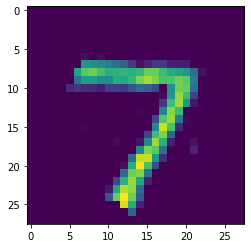

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
              loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
model.evaluate(test_data, test_data, verbose=2)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)));

Before running the same training in NengoDL, we'll change the Nengo model parameters to more closely match the TensorFlow network (we omitted these details in the original presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are essentially temporal, so data is described over time (indicating what the inputs/targets should be on each simulation timestep).  So instead of the data having shape `(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll just be training for a single timestep, but we still need to add that extra axis with length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples
Epoch 1/2


   50/60000 [..............................] - ETA: 4:23 - loss: 6490.1758 - probe_loss: 6490.1758

  800/60000 [..............................] - ETA: 20s - loss: 4769.6335 - probe_loss: 4769.6338 

 1550/60000 [..............................] - ETA: 12s - loss: 4192.1424 - probe_loss: 4192.1426

 2300/60000 [>.............................] - ETA: 9s - loss: 3786.8963 - probe_loss: 3786.8960 

 3050/60000 [>.............................] - ETA: 7s - loss: 3488.1939 - probe_loss: 3488.1938

 3800/60000 [>.............................] - ETA: 7s - loss: 3256.7471 - probe_loss: 3256.7471

 4550/60000 [=>............................] - ETA: 6s - loss: 3079.2330 - probe_loss: 3079.2334

 5300/60000 [=>............................] - ETA: 5s - loss: 2934.8242 - probe_loss: 2934.8242

 6050/60000 [==>...........................] - ETA: 5s - loss: 2815.9654 - probe_loss: 2815.9656

 6800/60000 [==>...........................] - ETA: 5s - loss: 2712.1595 - probe_loss: 2712.1597

 7550/60000 [==>...........................] - ETA: 5s - loss: 2619.1537 - probe_loss: 2619.1538

 8300/60000 [===>..........................] - ETA: 4s - loss: 2546.2896 - probe_loss: 2546.2898

 9050/60000 [===>..........................] - ETA: 4s - loss: 2475.2656 - probe_loss: 2475.2659

 9800/60000 [===>..........................] - ETA: 4s - loss: 2414.9965 - probe_loss: 2414.9971

10550/60000 [====>.........................] - ETA: 4s - loss: 2358.4420 - probe_loss: 2358.4426

11300/60000 [====>.........................] - ETA: 4s - loss: 2307.0584 - probe_loss: 2307.0588

12050/60000 [=====>........................] - ETA: 4s - loss: 2258.7166 - probe_loss: 2258.7170

12850/60000 [=====>........................] - ETA: 4s - loss: 2214.9589 - probe_loss: 2214.9592

13600/60000 [=====>........................] - ETA: 3s - loss: 2175.6615 - probe_loss: 2175.6621

14350/60000 [======>.......................] - ETA: 3s - loss: 2141.3240 - probe_loss: 2141.3242

15100/60000 [======>.......................] - ETA: 3s - loss: 2104.5817 - probe_loss: 2104.5820

15850/60000 [======>.......................] - ETA: 3s - loss: 2073.2609 - probe_loss: 2073.2612

16600/60000 [=======>......................] - ETA: 3s - loss: 2043.5776 - probe_loss: 2043.5779

17400/60000 [=======>......................] - ETA: 3s - loss: 2015.1753 - probe_loss: 2015.1757

18150/60000 [========>.....................] - ETA: 3s - loss: 1989.1414 - probe_loss: 1989.1417

18900/60000 [========>.....................] - ETA: 3s - loss: 1962.4728 - probe_loss: 1962.4728

19650/60000 [========>.....................] - ETA: 3s - loss: 1937.7443 - probe_loss: 1937.7444

20400/60000 [=========>....................] - ETA: 3s - loss: 1914.4350 - probe_loss: 1914.4352

21200/60000 [=========>....................] - ETA: 3s - loss: 1891.9351 - probe_loss: 1891.9349

21950/60000 [=========>....................] - ETA: 2s - loss: 1871.5008 - probe_loss: 1871.5010

22700/60000 [==========>...................] - ETA: 2s - loss: 1851.8833 - probe_loss: 1851.8833

23450/60000 [==========>...................] - ETA: 2s - loss: 1833.4506 - probe_loss: 1833.4506

24200/60000 [===========>..................] - ETA: 2s - loss: 1815.7512 - probe_loss: 1815.7515

24950/60000 [===========>..................] - ETA: 2s - loss: 1797.7896 - probe_loss: 1797.7898

25700/60000 [===========>..................] - ETA: 2s - loss: 1782.5089 - probe_loss: 1782.5093

26450/60000 [============>.................] - ETA: 2s - loss: 1766.9470 - probe_loss: 1766.9475

27200/60000 [============>.................] - ETA: 2s - loss: 1751.7474 - probe_loss: 1751.7478

27950/60000 [============>.................] - ETA: 2s - loss: 1738.0637 - probe_loss: 1738.0641

28700/60000 [=============>................] - ETA: 2s - loss: 1723.6338 - probe_loss: 1723.6342

29450/60000 [=============>................] - ETA: 2s - loss: 1710.0615 - probe_loss: 1710.0616

30150/60000 [==============>...............] - ETA: 2s - loss: 1697.3821 - probe_loss: 1697.3822

30900/60000 [==============>...............] - ETA: 2s - loss: 1685.1390 - probe_loss: 1685.1392

31550/60000 [==============>...............] - ETA: 2s - loss: 1674.4030 - probe_loss: 1674.4036

32150/60000 [===============>..............] - ETA: 2s - loss: 1665.0392 - probe_loss: 1665.0398

32900/60000 [===============>..............] - ETA: 2s - loss: 1654.6807 - probe_loss: 1654.6814

33650/60000 [===============>..............] - ETA: 1s - loss: 1643.4590 - probe_loss: 1643.4601

34400/60000 [================>.............] - ETA: 1s - loss: 1632.9003 - probe_loss: 1632.9014

35150/60000 [================>.............] - ETA: 1s - loss: 1622.6812 - probe_loss: 1622.6823

35900/60000 [================>.............] - ETA: 1s - loss: 1612.6747 - probe_loss: 1612.6760

36650/60000 [=================>............] - ETA: 1s - loss: 1603.7255 - probe_loss: 1603.7267

37350/60000 [=================>............] - ETA: 1s - loss: 1595.6044 - probe_loss: 1595.6056

38100/60000 [==================>...........] - ETA: 1s - loss: 1586.9214 - probe_loss: 1586.9226

38850/60000 [==================>...........] - ETA: 1s - loss: 1578.6029 - probe_loss: 1578.6039

39600/60000 [==================>...........] - ETA: 1s - loss: 1570.0609 - probe_loss: 1570.0620

40350/60000 [===================>..........] - ETA: 1s - loss: 1561.6004 - probe_loss: 1561.6014

41100/60000 [===================>..........] - ETA: 1s - loss: 1553.8273 - probe_loss: 1553.8284

41850/60000 [===================>..........] - ETA: 1s - loss: 1545.8506 - probe_loss: 1545.8517

42600/60000 [====================>.........] - ETA: 1s - loss: 1538.5218 - probe_loss: 1538.5227

43350/60000 [====================>.........] - ETA: 1s - loss: 1530.6378 - probe_loss: 1530.6390

44100/60000 [=====================>........] - ETA: 1s - loss: 1523.6433 - probe_loss: 1523.6445

44800/60000 [=====================>........] - ETA: 1s - loss: 1516.2874 - probe_loss: 1516.2887

45550/60000 [=====================>........] - ETA: 1s - loss: 1509.3820 - probe_loss: 1509.3831

46300/60000 [======================>.......] - ETA: 1s - loss: 1502.4022 - probe_loss: 1502.4034

47050/60000 [======================>.......] - ETA: 0s - loss: 1495.4326 - probe_loss: 1495.4340

47800/60000 [======================>.......] - ETA: 0s - loss: 1488.5967 - probe_loss: 1488.5981

48550/60000 [=======================>......] - ETA: 0s - loss: 1481.9295 - probe_loss: 1481.9310

49250/60000 [=======================>......] - ETA: 0s - loss: 1475.8482 - probe_loss: 1475.8496

49950/60000 [=======================>......] - ETA: 0s - loss: 1469.5402 - probe_loss: 1469.5417

50650/60000 [========================>.....] - ETA: 0s - loss: 1464.2438 - probe_loss: 1464.2457

51400/60000 [========================>.....] - ETA: 0s - loss: 1458.3121 - probe_loss: 1458.3138

52150/60000 [=========================>....] - ETA: 0s - loss: 1452.8078 - probe_loss: 1452.8096

52900/60000 [=========================>....] - ETA: 0s - loss: 1447.0244 - probe_loss: 1447.0260

53450/60000 [=========================>....] - ETA: 0s - loss: 1442.8366 - probe_loss: 1442.8380

54050/60000 [==========================>...] - ETA: 0s - loss: 1438.4698 - probe_loss: 1438.4711

54800/60000 [==========================>...] - ETA: 0s - loss: 1432.7453 - probe_loss: 1432.7465

55550/60000 [==========================>...] - ETA: 0s - loss: 1427.0843 - probe_loss: 1427.0856

56300/60000 [===========================>..] - ETA: 0s - loss: 1422.2328 - probe_loss: 1422.2340

57000/60000 [===========================>..] - ETA: 0s - loss: 1416.8646 - probe_loss: 1416.8658

57650/60000 [===========================>..] - ETA: 0s - loss: 1412.2878 - probe_loss: 1412.2888

58400/60000 [============================>.] - ETA: 0s - loss: 1407.1038 - probe_loss: 1407.1046

59150/60000 [============================>.] - ETA: 0s - loss: 1401.8090 - probe_loss: 1401.8099

59900/60000 [============================>.] - ETA: 0s - loss: 1396.5214 - probe_loss: 1396.5223

60000/60000 [==============================] - 4s 73us/sample - loss: 1395.9103 - probe_loss: 1395.9113


Epoch 2/2
   50/60000 [..............................] - ETA: 6s - loss: 866.2892 - probe_loss: 866.2892

  800/60000 [..............................] - ETA: 4s - loss: 976.2088 - probe_loss: 976.2087

 1500/60000 [..............................] - ETA: 4s - loss: 956.4442 - probe_loss: 956.4442

 2250/60000 [>.............................] - ETA: 4s - loss: 976.7204 - probe_loss: 976.7205

 3000/60000 [>.............................] - ETA: 3s - loss: 973.6973 - probe_loss: 973.6974

 3750/60000 [>.............................] - ETA: 3s - loss: 979.4570 - probe_loss: 979.4572

 4500/60000 [=>............................] - ETA: 3s - loss: 984.2922 - probe_loss: 984.2924

 5250/60000 [=>............................] - ETA: 3s - loss: 987.9561 - probe_loss: 987.9562

 6000/60000 [==>...........................] - ETA: 3s - loss: 984.8793 - probe_loss: 984.8795

 6750/60000 [==>...........................] - ETA: 3s - loss: 980.7175 - probe_loss: 980.7176

 7500/60000 [==>...........................] - ETA: 3s - loss: 978.2166 - probe_loss: 978.2166

 8250/60000 [===>..........................] - ETA: 3s - loss: 977.3172 - probe_loss: 977.3173

 9000/60000 [===>..........................] - ETA: 3s - loss: 979.3525 - probe_loss: 979.3525

 9750/60000 [===>..........................] - ETA: 3s - loss: 979.3515 - probe_loss: 979.3516

10500/60000 [====>.........................] - ETA: 3s - loss: 979.2817 - probe_loss: 979.2818

11250/60000 [====>.........................] - ETA: 3s - loss: 979.6884 - probe_loss: 979.6885

12000/60000 [=====>........................] - ETA: 3s - loss: 980.2151 - probe_loss: 980.2153

12750/60000 [=====>........................] - ETA: 3s - loss: 979.1949 - probe_loss: 979.1949

13500/60000 [=====>........................] - ETA: 3s - loss: 978.8038 - probe_loss: 978.8038

14250/60000 [======>.......................] - ETA: 3s - loss: 978.2135 - probe_loss: 978.2136

15000/60000 [======>.......................] - ETA: 3s - loss: 977.7232 - probe_loss: 977.7232

15750/60000 [======>.......................] - ETA: 3s - loss: 976.0710 - probe_loss: 976.0709

16500/60000 [=======>......................] - ETA: 2s - loss: 974.5208 - probe_loss: 974.5209

17250/60000 [=======>......................] - ETA: 2s - loss: 973.5761 - probe_loss: 973.5763

18000/60000 [========>.....................] - ETA: 2s - loss: 973.7436 - probe_loss: 973.7437

18750/60000 [========>.....................] - ETA: 2s - loss: 972.5034 - probe_loss: 972.5036

19500/60000 [========>.....................] - ETA: 2s - loss: 972.4262 - probe_loss: 972.4264

20250/60000 [=========>....................] - ETA: 2s - loss: 970.4924 - probe_loss: 970.4926

21000/60000 [=========>....................] - ETA: 2s - loss: 968.8357 - probe_loss: 968.8359

21750/60000 [=========>....................] - ETA: 2s - loss: 967.6269 - probe_loss: 967.6271

22500/60000 [==========>...................] - ETA: 2s - loss: 967.3161 - probe_loss: 967.3162

23250/60000 [==========>...................] - ETA: 2s - loss: 966.7094 - probe_loss: 966.7095

23900/60000 [==========>...................] - ETA: 2s - loss: 967.2097 - probe_loss: 967.2098

24650/60000 [===========>..................] - ETA: 2s - loss: 966.1428 - probe_loss: 966.1429

25400/60000 [===========>..................] - ETA: 2s - loss: 965.6872 - probe_loss: 965.6873

26150/60000 [============>.................] - ETA: 2s - loss: 965.5386 - probe_loss: 965.5386

26900/60000 [============>.................] - ETA: 2s - loss: 963.0779 - probe_loss: 963.0781

27650/60000 [============>.................] - ETA: 2s - loss: 962.6181 - probe_loss: 962.6185

28400/60000 [=============>................] - ETA: 2s - loss: 961.8611 - probe_loss: 961.8613

29150/60000 [=============>................] - ETA: 2s - loss: 961.0502 - probe_loss: 961.0505

29900/60000 [=============>................] - ETA: 2s - loss: 960.5759 - probe_loss: 960.5763

30650/60000 [==============>...............] - ETA: 2s - loss: 960.4134 - probe_loss: 960.4138

31400/60000 [==============>...............] - ETA: 1s - loss: 960.0393 - probe_loss: 960.0395

32150/60000 [===============>..............] - ETA: 1s - loss: 959.6501 - probe_loss: 959.6503

32900/60000 [===============>..............] - ETA: 1s - loss: 959.0545 - probe_loss: 959.0547

33650/60000 [===============>..............] - ETA: 1s - loss: 958.8004 - probe_loss: 958.8004

34400/60000 [================>.............] - ETA: 1s - loss: 959.1418 - probe_loss: 959.1417

35150/60000 [================>.............] - ETA: 1s - loss: 958.7059 - probe_loss: 958.7058

35850/60000 [================>.............] - ETA: 1s - loss: 957.9290 - probe_loss: 957.9291

36600/60000 [=================>............] - ETA: 1s - loss: 957.0356 - probe_loss: 957.0356

37350/60000 [=================>............] - ETA: 1s - loss: 956.7481 - probe_loss: 956.7482

38100/60000 [==================>...........] - ETA: 1s - loss: 956.4561 - probe_loss: 956.4561

38850/60000 [==================>...........] - ETA: 1s - loss: 956.0422 - probe_loss: 956.0424

39600/60000 [==================>...........] - ETA: 1s - loss: 955.3963 - probe_loss: 955.3965

40350/60000 [===================>..........] - ETA: 1s - loss: 955.0513 - probe_loss: 955.0515

41100/60000 [===================>..........] - ETA: 1s - loss: 954.9998 - probe_loss: 954.9999

41850/60000 [===================>..........] - ETA: 1s - loss: 954.5857 - probe_loss: 954.5859

42600/60000 [====================>.........] - ETA: 1s - loss: 954.2845 - probe_loss: 954.2845

43350/60000 [====================>.........] - ETA: 1s - loss: 953.2200 - probe_loss: 953.2202

44100/60000 [=====================>........] - ETA: 1s - loss: 951.9348 - probe_loss: 951.9348

44850/60000 [=====================>........] - ETA: 1s - loss: 951.5493 - probe_loss: 951.5493

45600/60000 [=====================>........] - ETA: 0s - loss: 951.1447 - probe_loss: 951.1447

46350/60000 [======================>.......] - ETA: 0s - loss: 951.3387 - probe_loss: 951.3386

47150/60000 [======================>.......] - ETA: 0s - loss: 951.0119 - probe_loss: 951.0117

47950/60000 [======================>.......] - ETA: 0s - loss: 950.7963 - probe_loss: 950.7961

48600/60000 [=======================>......] - ETA: 0s - loss: 949.9791 - probe_loss: 949.9789

49400/60000 [=======================>......] - ETA: 0s - loss: 949.6019 - probe_loss: 949.6019

50150/60000 [========================>.....] - ETA: 0s - loss: 949.1060 - probe_loss: 949.1060

50900/60000 [========================>.....] - ETA: 0s - loss: 948.6225 - probe_loss: 948.6225

51650/60000 [========================>.....] - ETA: 0s - loss: 947.7224 - probe_loss: 947.7224

52400/60000 [=========================>....] - ETA: 0s - loss: 947.2779 - probe_loss: 947.2778

53150/60000 [=========================>....] - ETA: 0s - loss: 946.7459 - probe_loss: 946.7459

53900/60000 [=========================>....] - ETA: 0s - loss: 946.3990 - probe_loss: 946.3989

54650/60000 [==========================>...] - ETA: 0s - loss: 945.6704 - probe_loss: 945.6703

55400/60000 [==========================>...] - ETA: 0s - loss: 945.2009 - probe_loss: 945.2009

56150/60000 [===========================>..] - ETA: 0s - loss: 944.9363 - probe_loss: 944.9365

56900/60000 [===========================>..] - ETA: 0s - loss: 944.3788 - probe_loss: 944.3788

57650/60000 [===========================>..] - ETA: 0s - loss: 943.7367 - probe_loss: 943.7369

58400/60000 [============================>.] - ETA: 0s - loss: 943.4205 - probe_loss: 943.4207

59150/60000 [============================>.] - ETA: 0s - loss: 943.2911 - probe_loss: 943.2912

59900/60000 [============================>.] - ETA: 0s - loss: 942.7437 - probe_loss: 942.7438

60000/60000 [==============================] - 4s 68us/sample - loss: 942.6421 - probe_loss: 942.6422


10000/10000 - 1s - loss: 933.4836 - probe_loss: 933.4838


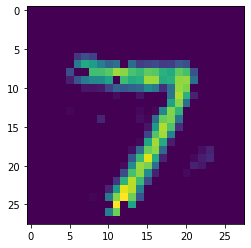

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
                loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data, verbose=2)

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)));

More details on using `sim.fit` can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering Framework (NEF).  This uses linear least-squares optimization to solve for optimal connection weights analytically, rather than using an iterative gradient-descent based algorithm.  The advantage of the NEF is that it is very fast and general (for example, it does not require the network to be differentiable).  The disadvantage is that it optimizes each set of connection weights individually (i.e., it cannot jointly optimize across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a `nengo.Connection`.  This specifies the function that we would like those connection weights to approximate.  In addition, in previous examples you may have noticed that we were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using `ensemble.neurons` specifies that we want to form a direct connection between ensemble neurons, without applying the NEF optimization.  So when we want to use the `function` argument, the `Connection` source object should be an `ensemble`, not `ensemble.neurons`.  For example, we could use the NEF to create a network to approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

|##############Constructing graph: build stage (90%)######       | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                     Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

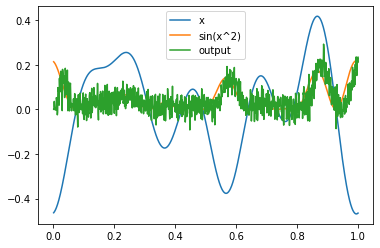

In [17]:
with nengo.Network(seed=0) as net:    
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))
    
    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)
    
    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)
    
    # output node
    outpt = nengo.Node(size_in=1)
    
    # connect input to first ensemble
    nengo.Connection(inpt, ens0)
    
    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)
    
    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)
    
    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt)
    
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

The NEF optimization can be used in combination with the deep learning optimization methods.  For example, we could optimize some parameters with the NEF and others with `sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).  Or we could initialize each set of connection weights individually with the NEF, and then further refine them with end-to-end training via `sim.fit`.  As always, the overall theme is that NengoDL allows us to use whichever method is most appropriate for a particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic networks quickly/efficiently.  However, often it is difficult to program this custom hardware, and it requires writing custom code for each neuromorphic platform.  One of the primary design goals of Nengo is to alleviate these challenges, by providing a single API that can be used to build networks across many different neuromorphic platforms.  

The idea is that the front-end network construction code is the same (`Networks`, `Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own `Simulator` class (the back-end) that compiles and executes that network definition for some compute platform.  This provides a consistent interface so that we only need to write code once and can then run that network on novel hardware platforms with no additional effort.  For example, we could take the network from above and simulate it on different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

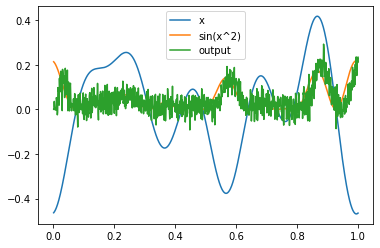

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
# run on Loihi neuromorphic hardware 
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware 
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)
    
# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

We have commented out the different backends above because they require extra installation steps, but if you are running this example yourself you can install any of those backends (or more) and uncomment that code to see the same network running on that new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end (among other things); it takes a standard Nengo network, and simulates it using TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate NengoDL's deep learning functionality into any other Nengo back-end.  We build our Network, optimize it in NengoDL, save the optimized model parameters back into the Network definition, and then simulate that optimized Network in a different back-end.  See [this example in nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL, including network construction, execution, and optimization.  We have also discussed how to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the unique features of Nengo (such as NEF optimization and neuromorphic cross-platform execution).  However, there is much more functionality in NengoDL than we are able to introduce here; check out the [user guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you would like more information on how NengoDL is implemented under the hood using TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).